# Generating and Segmenting with Character-Level Transformer

In [1]:
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

from src.models.gpt2 import GPT2FeatureModel, GPT2LMHeadModel
from src.preprocessing import create_phoneme_map

phoible = pd.read_csv('../../data/phoible.csv')

MODEL_NAME = 'phonemetransformers/childes-multilingual-5M-gpt2_lm-model'
# REVISION = '7f0fc5f0f184c73932fe7a674e65178ebab3e662'
# LANGUAGE = 'Spanish'

# REVISION = '45ff3df059c986c293d657d84e17179a39d1b0f2'
# LANGUAGE = 'English'

REVISION = '71df1412f2df7e2ff972e864e92abd21e05b305c'
LANGUAGE = 'French'

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_9186/1461309015.py:13: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../../data/phoible.csv')


## Load model

In [2]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, revision=REVISION)
phoneme_map = create_phoneme_map(tokenizer, '../../data/phoible.csv')
#model = GPT2FeatureModel.from_pretrained('transformersegmentation/GPT2-gpt2_feature_model-model', revision='english', feature_map=phoneme_map)
#model.return_token_logits = True
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME, revision=REVISION)

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/PhonemeTransformers/analysis/segmentation/../../src/preprocessing.py:63: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


## Load corpus

In [3]:
dataset = load_dataset('phonemetransformers/CHILDES', LANGUAGE, split='train')
dataset = dataset.select(range(10000))

## Generate Text

In [4]:
# Generate a sample
input_ids = tokenizer.encode('s', return_tensors='pt')
print('Greedy decoding:')
print(tokenizer.decode(model.generate(input_ids,
                                      max_length=50,
                                      pad_token_id=tokenizer.pad_token_id,
                                      early_stopping=False,
                                      eos_token_id=tokenizer.pad_token_id,
                                      no_repeat_ngram_size=3)[0], skip_special_tokens=False))

print('Beam search decoding:')
print(tokenizer.decode(model.generate(input_ids,
                                      do_sample=False,
                                      max_length=50,
                                      num_beams=4,
                                      pad_token_id=tokenizer.pad_token_id,
                                      early_stopping=False,
                                      eos_token_id=tokenizer.pad_token_id,
                                      no_repeat_ngram_size=3)[0], skip_special_tokens=False))

print('Sampling decoding:')
print(tokenizer.decode(model.generate(input_ids,
                                      do_sample=True,
                                      max_length=50,
                                      top_k=0,
                                      top_p=0.95,
                                      num_return_sequences=1,
                                      pad_token_id=tokenizer.pad_token_id,
                                      early_stopping=False,
                                      eos_token_id=tokenizer.pad_token_id,
                                      no_repeat_ngram_size=3)[0], skip_special_tokens=False))


# sample_outputs = model.generate(input_ids, do_sample=True, num_beams=4, max_length=50, top_k=10, top_p=0.95, num_return_sequences=1, pad_token_id=tokenizer.pad_token_id)
# for i, sample_output in enumerate(sample_outputs):
#     print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Greedy decoding:
UTT_BOUNDARY s ɛ t œ p ə t i p ø d ə p ə l y ʃ UTT_BOUNDARY s a s ɛ l ə p a p a UTT_BOUNDARY s ə l i v ʁ UTT_BOUNDARY s i s ɛ p a z œ p a ʁ t ɛ
Beam search decoding:
UTT_BOUNDARY s a s ɛ k w a s a UTT_BOUNDARY s ɛ t y n p ə t i t p a t a m o d l e UTT_BOUNDARY t y v ø k ə ʒ ə l ə m ɛ t d ɑ̃ l a b u
Sampling decoding:
UTT_BOUNDARY s ɛ t œ n i a p a ʁ t u UTT_BOUNDARY w ɛ s y p ɛ ʁ UTT_BOUNDARY ɔ m i a œ s ɛ ʁ p ɑ̃ p a k ɔ̃ t ɑ̃ t s a UTT_BOUNDARY ɔ UTT_BOUNDARY a w ɛ UTT_BOUNDARY t y


## Prediction Error

Plotting of prediction error from a model given a prompt.

In [5]:
from src.evaluation.segmentation import GPT2FeaturesSegmenter, GPT2Segmenter
segmenter = GPT2Segmenter(model, tokenizer, dataset['phonemized_utterance'], stride=10, batch_size=32)
#segmenter = GPT2FeaturesSegmenter(model, tokenizer, dataset['train']['phonemized_utterance'][:3000], stride=0)

100%|██████████| 349/349 [00:37<00:00,  9.41it/s]


In [6]:
def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)

        cutoff = cutoffs[i] if cutoffs else None
        for j in range(len(ax.get_xticklabels())):
            tick = ax.get_xticklabels()[j]
            is_boundary = data.Starts[j]
            y_value = data[measures[i]].values[j]
            # Add vertical line at boundary
            if is_boundary:
                ax.axvline(x=j, color='grey', alpha=0.5)
            # Set tick to green if correct boundary according to cutoff
            if cutoff:
                tick.set_color('green' if (is_boundary and y_value >= cutoff) or (not is_boundary and y_value < cutoff) else 'red')

        # Add cutoff line   
        if cutoff:
            ax.axhline(y=cutoff, color='pink', alpha=0.5)

    ax.set_xlabel('Phonemes')
    plt.show()

def get_cutoff_data(segmenter, measure, cutoffs):
    """ Get results for a specific measure at different cutoffs. """
    all_results = []
    for cutoff in cutoffs:
        results = segmenter.evaluate_cutoff_segmentation(measure, cutoff)
        results['Cutoff'] = cutoff
        all_results.append(results)
    all_results = pd.concat(all_results)
    return all_results

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = sns.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    sns.lineplot(results, x=measure1, y=measure2)
    plt.show()

def plot_optimal_cutoff(segmenter, measure, score, cutoff):

    min, max = segmenter.processed_utterances[measure].min(), segmenter.processed_utterances[measure].max()
    cutoffs = np.linspace(min, max, 50)
    scores = [segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score] for cutoff in cutoffs]
    graph = sns.lineplot(x=cutoffs, y=scores)
    graph.axvline(cutoff, color='grey', alpha=0.5)
    plt.show()

def summarise_segmentation(segmenter, measure='Entropy', score='type_fscore', cutoff=None, show_plots=False):
    spike_data = segmenter.evaluate_spike_segmentation(measure)
    print('Spike {}: {}'.format(score, round(spike_data[score]*100,2)))
    if cutoff:
        best_cutoff = cutoff
        best_result = segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score]
    else:
        best_cutoff, best_result = segmenter.find_best_cutoff(measure, score)
        print('Best cutoff:', best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))
    if show_plots:
        plot_optimal_cutoff(segmenter, measure, score, best_cutoff)


In [7]:
all_measures = ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Increase in Boundary Prediction', 'Loss', 'Increase in Loss', 'Rank', 'Increase in Rank']
all_measures = ['Entropy', 'Boundary Prediction', 'Loss', 'Rank']
best_cutoffs = {measure : segmenter.find_best_cutoff(measure, 'boundary_noedge_fscore')[0] for measure in all_measures}

print("Best cutoffs: ", best_cutoffs)

Best cutoffs:  {'Entropy': 1.5195359247026354, 'Boundary Prediction': 0.0013228872287960442, 'Loss': 0.9170240409239101, 'Rank': 1.093302001618794}


In [8]:
# segmenter.processed_utterances['Majority Vote Cutoff'] = 0
# segmenter.processed_utterances['Majority Vote Spike'] = 0
# for measure in all_measures:
#     segmenter.processed_utterances['Majority Vote Cutoff'] += (segmenter.processed_utterances[measure] >= best_cutoffs[measure]).astype(int)
#     shift_left = segmenter.processed_utterances[measure].shift(1)
#     shift_right = segmenter.processed_utterances[measure].shift(-1)
#     segmenter.processed_utterances['Majority Vote Spike'] += ((segmenter.processed_utterances[measure] > shift_left) & (segmenter.processed_utterances[measure] > shift_right)).astype(int)

segmenter.add_majority_vote(best_cutoffs)

best_cutoffs['Majority Vote Cutoff'] = 0.5
best_cutoffs['Majority Vote Spike'] = 0.5
all_measures += ['Majority Vote Cutoff', 'Majority Vote Spike']

In [9]:
example_utterance = segmenter.processed_utterances.loc[0:64].copy()
example_utterance.Phoneme = example_utterance.Phoneme.apply(lambda x: x if x != 'UTT_BOUNDARY' else ' ')

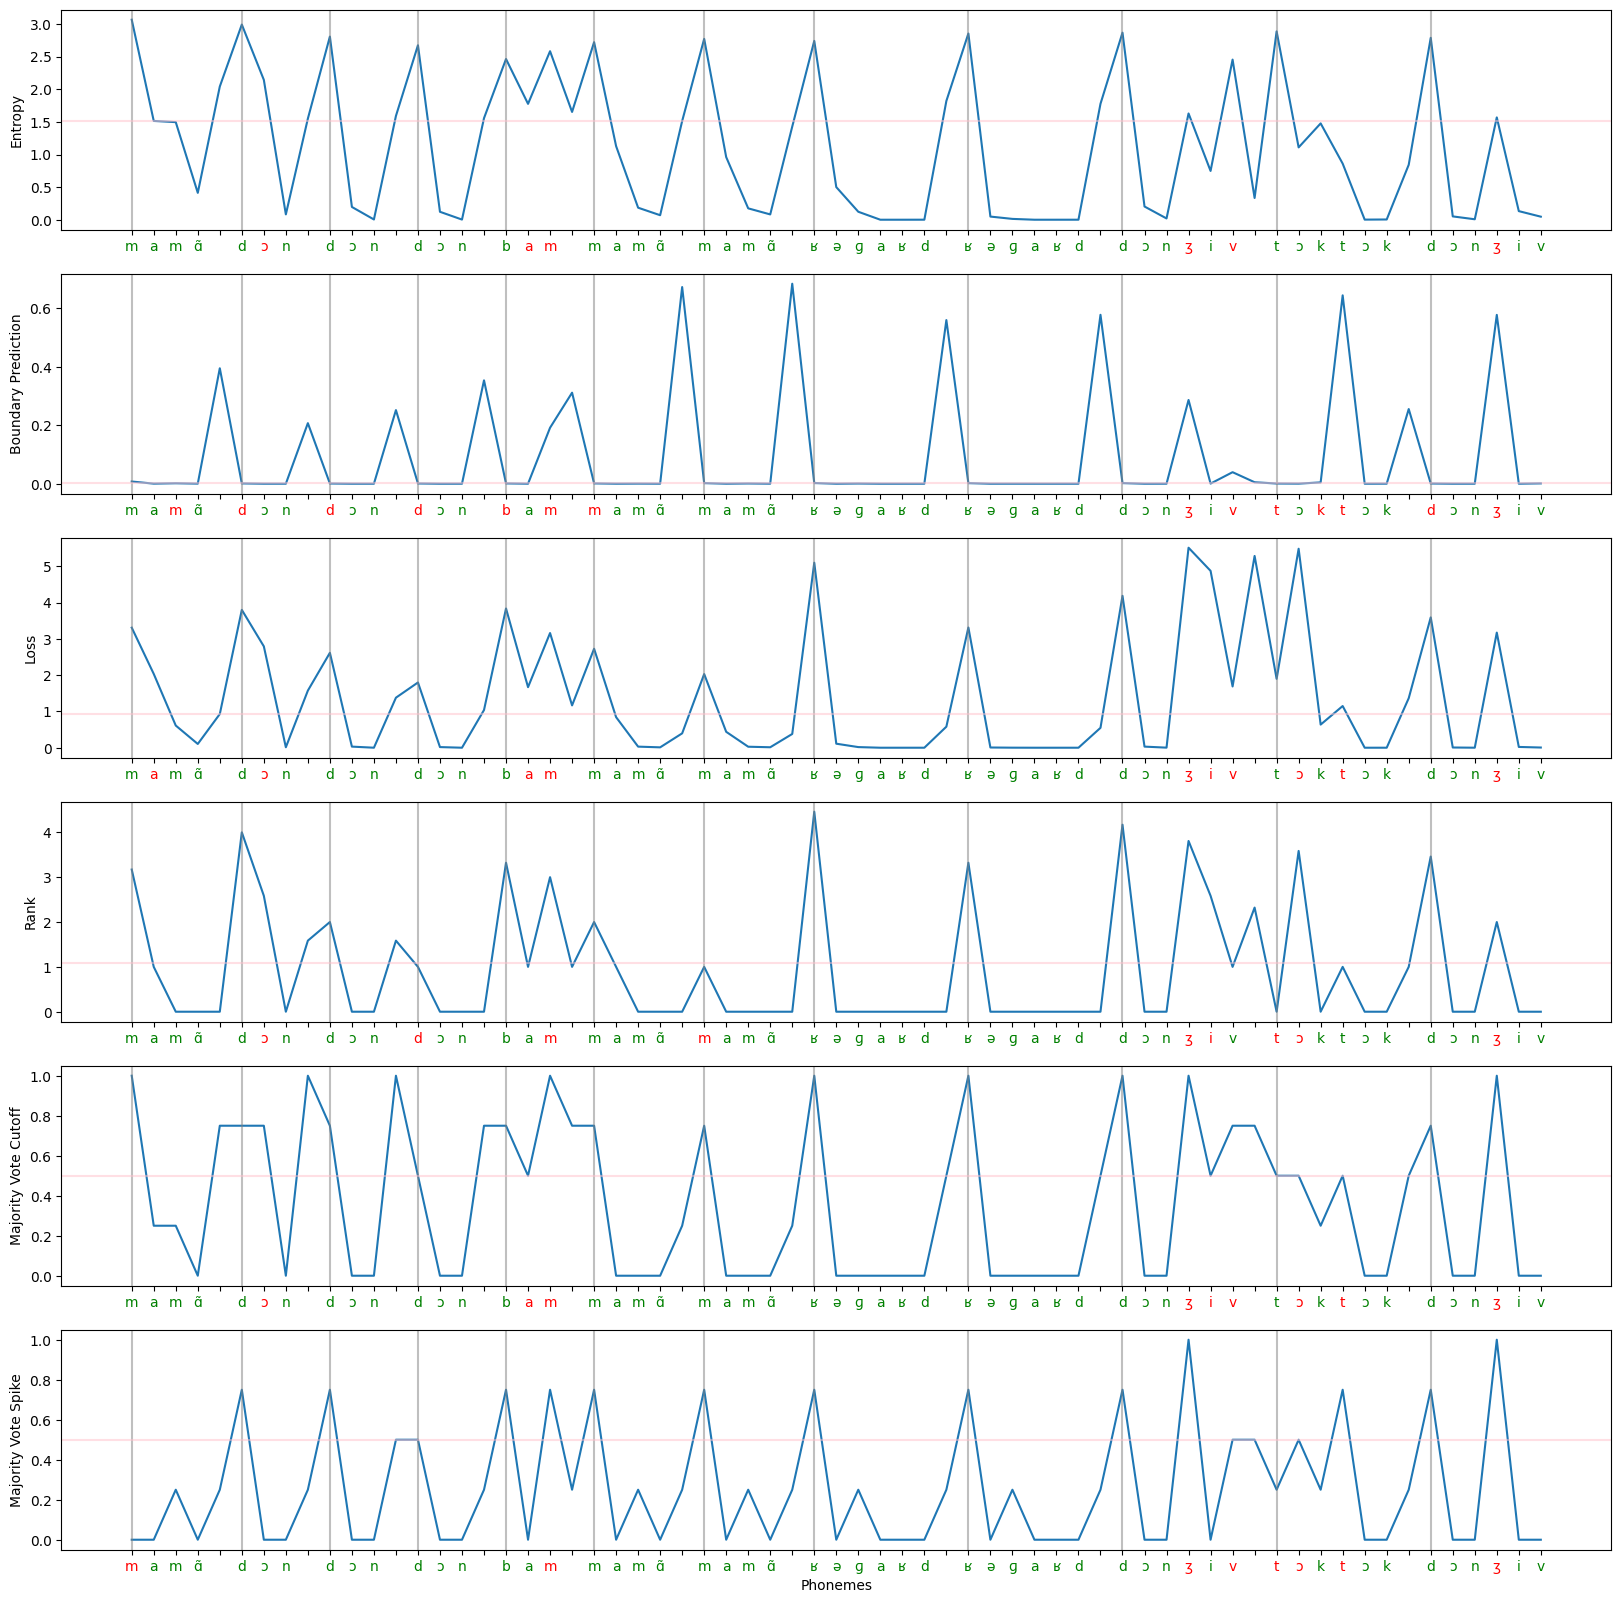

mamɑ̃ dɔn dɔn dɔn bam mamɑ̃ mamɑ̃ ʁəɡaʁd ʁəɡaʁd dɔnʒiv tɔktɔk dɔnʒiv


In [10]:
plot_utterance(example_utterance, list(best_cutoffs.keys()), list(best_cutoffs.values()))
#plot_utterance(data, ['Feature Loss', 'Feature Entropy', 'Loss Deviation', 'Boundary Feature Prediction'], [0.01, 0.3, 0.01, 0.5])
print(''.join(list(example_utterance.Phoneme)))

In [11]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', best_cutoffs[measure], show_plots=False)
#for measure in ['Feature Loss', 'Increase in Feature Loss', 'Feature Entropy', 'Increase in Feature Entropy', 'Loss Deviation', 'Increase in Loss Deviation', 'Boundary Feature Prediction', 'Increase in Boundary Feature Prediction']:


Entropy
Spike type_fscore: 29.68
Best type_fscore at cutoff 1.5195359247026354: 28.58

Boundary Prediction
Spike type_fscore: 33.3
Best type_fscore at cutoff 0.0013228872287960442: 39.6

Loss
Spike type_fscore: 26.26
Best type_fscore at cutoff 0.9170240409239101: 26.33

Rank
Spike type_fscore: 24.89
Best type_fscore at cutoff 1.093302001618794: 22.29

Majority Vote Cutoff
Spike type_fscore: 31.43
Best type_fscore at cutoff 0.5: 34.28

Majority Vote Spike
Spike type_fscore: 27.72
Best type_fscore at cutoff 0.5: 28.95


In [12]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', show_plots=False)


Entropy
Spike type_fscore: 29.68
Best cutoff: 1.066571564614326
Best type_fscore at cutoff 1.066571564614326: 30.53

Boundary Prediction
Spike type_fscore: 33.3
Best cutoff: 0.0013056697061116244
Best type_fscore at cutoff 0.0013056697061116244: 39.72

Loss
Spike type_fscore: 26.26
Best cutoff: 1.2344567548408658
Best type_fscore at cutoff 1.2344567548408658: 25.41

Rank
Spike type_fscore: 24.89
Best cutoff: 1.1908243446652427
Best type_fscore at cutoff 1.1908243446652427: 22.29

Majority Vote Cutoff
Spike type_fscore: 31.43
Best cutoff: 0.5834197893147185
Best type_fscore at cutoff 0.5834197893147185: 34.28

Majority Vote Spike
Spike type_fscore: 27.72
Best cutoff: 0.3819696292221213
Best type_fscore at cutoff 0.3819696292221213: 35.72


In [13]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=False, cutoff=best_cutoffs['Majority Vote Cutoff'])
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=False, cutoff=best_cutoffs['Majority Vote Spike'])

Spike boundary_noedge_fscore: 73.96
Best boundary_noedge_fscore at cutoff 0.5: 71.35
Spike boundary_noedge_fscore: 71.64
Best boundary_noedge_fscore at cutoff 0.5: 69.89


In [14]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=False)
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=False)

Spike boundary_noedge_fscore: 73.96
Best cutoff: 0.5216049232161126
Best boundary_noedge_fscore at cutoff 0.5216049232161126: 71.35
Spike boundary_noedge_fscore: 71.64
Best cutoff: 0.3819710156402218
Best boundary_noedge_fscore at cutoff 0.3819710156402218: 75.21


# Correlation with units

In [15]:
ends = []
max = len(segmenter.processed_utterances)
for i in range(max):
    if i + 1 == max:
        ends.append(False)
    elif segmenter.processed_utterances['Phoneme'][i+1] == 'UTT_BOUNDARY':
        ends.append(True)
    elif segmenter.processed_utterances['Phoneme'][i] == 'UTT_BOUNDARY':
        ends.append(False)
    elif segmenter.processed_utterances['Starts'][i+1]:
        ends.append(True)
    else:
        ends.append(False)

segmenter.processed_utterances['Ends'] = ends

In [16]:
import torch
from tqdm import tqdm
DEFAULT_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

boundary_token = tokenizer.convert_tokens_to_ids('UTT_BOUNDARY')
phonemes = segmenter.processed_utterances['Phoneme'].to_list()
MAX_SEQ_LEN = 64
STRIDE = 10

token_ids = tokenizer.convert_tokens_to_ids(phonemes)
long_input_ids = torch.tensor(token_ids, dtype=torch.long).to(DEFAULT_DEVICE)
input_ids = []
input_id_length = len(long_input_ids)
for begin_loc in range(0, len(long_input_ids), STRIDE):
    end_loc = min(begin_loc + MAX_SEQ_LEN, len(long_input_ids))
    inputs = long_input_ids[begin_loc:end_loc].to(DEFAULT_DEVICE)
    input_ids.append(inputs)
    if end_loc == input_id_length:
        break

# Pad final stride with 0s
input_ids[-1] = torch.cat((input_ids[-1], torch.zeros(MAX_SEQ_LEN - len(input_ids[-1]), dtype=torch.long).to(DEFAULT_DEVICE)))

# Stack into batches of batch_size
input_ids = torch.stack(input_ids)
input_ids = input_ids.view(-1, 1, MAX_SEQ_LEN)
seq_len = input_ids.size(0)

# Get activations from each batch and concatenate them
activations = {}
print('Extracting activations...')
for i in tqdm(range(seq_len)):
    with torch.no_grad():
        outputs = model(input_ids[i], return_dict=True, output_hidden_states=True)
        if activations == {}:
            activations = {j : [] for j in range(sum([o.shape[-1] for o in outputs.hidden_states]))}
            for j, o in enumerate(outputs.hidden_states):
                layer_size = o.shape[-1]
                for k in range(o.shape[-1]):
                    activations[j*layer_size+k].extend(o[0,:,k].cpu().numpy())
        else:
            for j, o in enumerate(outputs.hidden_states):
                layer_size = o.shape[-1]
                for k in range(o.shape[-1]):
                    activations[j*layer_size+k].extend(o[0,-STRIDE:,k].cpu().numpy())
activations = pd.DataFrame(activations)
activations = activations[:len(token_ids)]

Extracting activations...


100%|██████████| 11159/11159 [03:15<00:00, 56.94it/s]


In [17]:
# Find a correlation between the activations and Starts
from scipy.stats import spearmanr
correlations = {}
for column in activations.columns:
    correlations[column] = spearmanr(activations[column], segmenter.processed_utterances['Ends']).correlation
correlations = pd.Series(correlations)

# Ensure correlations are sorted correctly
correlations = pd.Series(correlations).astype(float)  # Convert to float if not already
correlations.sort_values(ascending=False, inplace=True)  # Sort in place

correlations

1618    0.602295
1613    0.484245
1649    0.466183
1595    0.366110
1689    0.358944
          ...   
1638   -0.389446
1594   -0.392782
1692   -0.449583
1639   -0.514345
1661   -0.676688
Length: 1792, dtype: float64

Optimal Threshold: -0.0787384882569313
0.8875996085558507


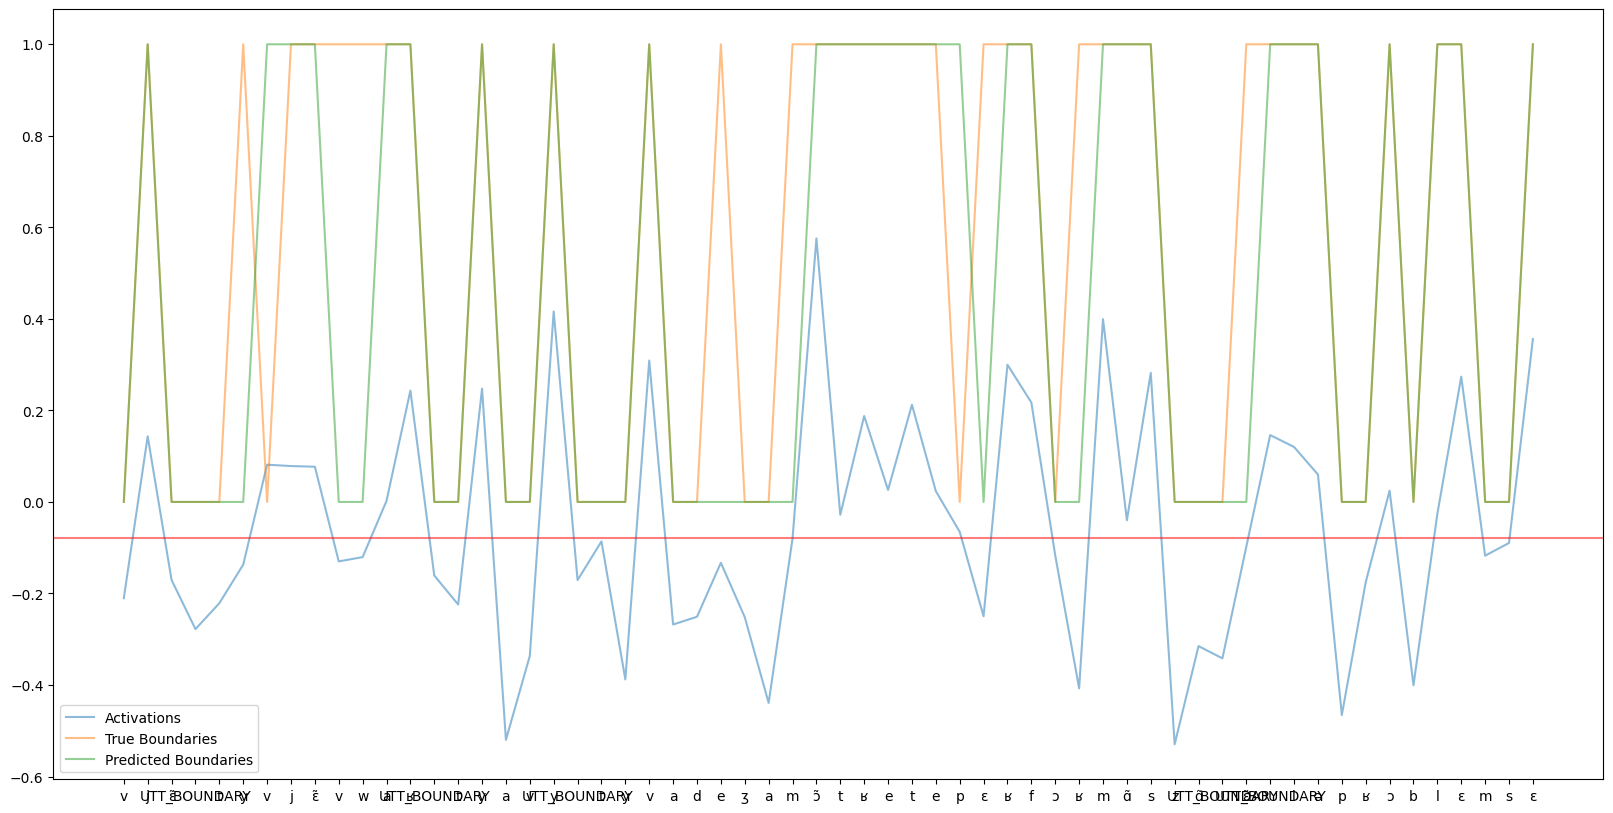

In [18]:
# Train a one parameter classifier that predicts word boundaries by thresholding the activations from a single unit in activations
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

if abs(correlations[0]) > abs(correlations[correlations.index[-1]]):
    X = activations[correlations.index[0]].values.reshape(-1, 1)
    y = segmenter.processed_utterances['Ends'].values
else:
    X = activations[correlations.index[-1]].values.reshape(-1, 1)
    y = ~segmenter.processed_utterances['Ends'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, X_train)

# Calculate Youden's J statistic
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold}')

y_pred = (X_test > optimal_threshold).astype(int)

# Print overall f1 score
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred))


# Plot the activations and the classifier's predictions
plt.figure(figsize=(20,10))
plt.plot(X_test[90:150], alpha=0.5)
plt.plot(y_test[90:150], alpha=0.5)
plt.plot(y_pred[90:150], alpha=0.5)
# add phonemes as x-axis labels
plt.xticks(range(60), segmenter.processed_utterances['Phoneme'].values[90:150])
plt.legend(['Activations', 'True Boundaries', 'Predicted Boundaries'])
# Add cutoff
plt.axhline(optimal_threshold, color='red', alpha=0.5)
plt.show()

In [19]:
# Train a classifier that predicts word boundaries by thresholding the activations from all units from units 1536 to 1792

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

X = activations[range(1536,1792)].values
y = segmenter.processed_utterances['Ends'].values

# Remove positions where the phoneme is an utterance boundary
X = X[segmenter.processed_utterances['Phoneme'] != 'UTT_BOUNDARY']
y = y[segmenter.processed_utterances['Phoneme'] != 'UTT_BOUNDARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f1_score(y_test, y_pred))

0.8771422943069145


In [20]:
y = segmenter.processed_utterances['Ends'].values
phons = segmenter.processed_utterances['Phoneme'].values
starts = segmenter.processed_utterances['Starts'].values

pos_idx = np.where(y == 1)[0]
neg_idx = np.where((y == 0) & (phons != 'UTT_BOUNDARY'))[0]
np.random.shuffle(pos_idx)
np.random.shuffle(neg_idx)

pos_train_idx = pos_idx[:300]
neg_train_idx = neg_idx[:300]
pos_idx = pos_idx[300:]
neg_idx = neg_idx[300:]

# Ensure test positions are not words in the training set
pos_val_idx = []
neg_val_idx = []
for idx in pos_idx:
    word_exists = False
    for train_idx in pos_train_idx:
        i = 0
        while phons[train_idx - i] == phons[idx - i]:
            if starts[train_idx - i] == True and starts[idx - i] == True:
                word_exists = True
                break
            i += 1
        if word_exists:
            break
    if not word_exists:
        pos_val_idx.append(idx)
for idx in neg_idx:
    word_exists = False
    for train_idx in neg_train_idx:
        i = 0
        while phons[train_idx - i] == phons[idx - i]:
            if starts[train_idx - i] == True and starts[idx - i] == True:
                word_exists = True
                break
            i += 1
        if word_exists:
            break
    if not word_exists:
        neg_val_idx.append(idx)

train_idx = np.concatenate((pos_train_idx, neg_train_idx))
np.random.shuffle(train_idx)

val_size = np.min([len(pos_val_idx), len(neg_val_idx)])
val_idx = np.concatenate((pos_val_idx[:val_size], neg_val_idx[:val_size]))
np.random.shuffle(val_idx)

print('Train size:', len(train_idx))
print('Val size:', len(val_idx))

Train size: 600
Val size: 25946


In [21]:
from sklearn.metrics import accuracy_score

X = activations[range(1536,1792)].values
y = segmenter.processed_utterances['Ends'].values

X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]

clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Print accuracy
print(accuracy_score(y_test, y_pred))

0.8558709233115254
